In [1]:
import pandas as pd
import numpy as np
import json
import nltk
import re
import csv
import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

%matplotlib inline
pd.set_option('display.max_colwidth', 300)

In [2]:
# function for text cleaning 
def clean_text(text):
    # remove backslash-apostrophe 
    text = re.sub("\'", "", text) 
    # remove everything except alphabets 
    text = re.sub("[^a-zA-Z]"," ",text) 
    # remove whitespaces 
    text = ' '.join(text.split()) 
    # convert text to lowercase 
    text = text.lower() 
    
    return text

In [3]:
input_df = pd.read_csv("output.csv")
input_df.describe()

,movie_name,genres
count,199280,199280
unique,173598,1270
top,Broken,['drama']
freq,27,31490


In [4]:
## for bag-of-words
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing
## for word embedding
import gensim
import gensim.downloader as gensim_api
## for deep learning
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K


In [5]:
#Get the total number of genres in the dataset
totalGenres = []
allGenres = []
for row in input_df['genres']:
    if row:
        temp = []
        curstr = row[1:-1]
        curGenres = curstr.split(',')
        for eachGenre in curGenres:
            allGenres.append(eachGenre.strip())
            temp.append(eachGenre.strip())
        totalGenres.append(temp)
input_df['new_genres'] = totalGenres

input_df.head()


,movie_name,genres,new_genres
0,Miss Jerry,['romance'],['romance']
1,Hamlet,['drama'],['drama']
2,The Fairylogue and Radio-Plays,"['adventure', 'fantasy']","['adventure', 'fantasy']"
3,"Hamlet, Prince of Denmark",['drama'],['drama']
4,The Life of Moses,"['biography', 'drama', 'family']","['biography', 'drama', 'family']"


In [6]:
allGenres = nltk.FreqDist(allGenres) 

In [7]:
all_genres_df = pd.DataFrame({'Genre': list(allGenres.keys()), 
                              'Count': list(allGenres.values())})

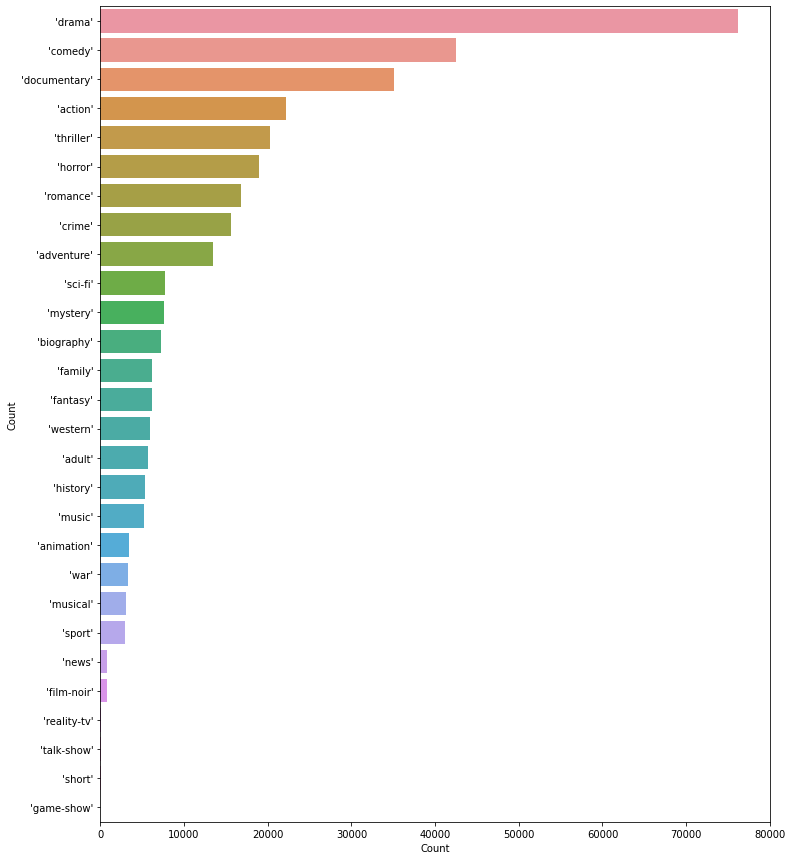

In [8]:
g = all_genres_df.nlargest(columns="Count", n = 50) 
plt.figure(figsize=(12,15)) 
ax = sns.barplot(data=g, x= "Count", y = "Genre") 
ax.set(ylabel = 'Count') 
plt.show()

In [31]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# function to remove stopwords
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

In [9]:
input_df['movie_name_new'] = input_df['movie_name'].apply(lambda x: clean_text(x))

In [10]:
input_df.head()

,movie_name,genres,new_genres,movie_name_new
0,Miss Jerry,['romance'],['romance'],miss jerry
1,Hamlet,['drama'],['drama'],hamlet
2,The Fairylogue and Radio-Plays,"['adventure', 'fantasy']","['adventure', 'fantasy']",the fairylogue and radio plays
3,"Hamlet, Prince of Denmark",['drama'],['drama'],hamlet prince of denmark
4,The Life of Moses,"['biography', 'drama', 'family']","['biography', 'drama', 'family']",the life of moses


In [11]:
# df = input_df.drop("genres", axis=1)
df= input_df.drop(['genres', 'movie_name'], axis=1)

In [12]:
# df = input_df.drop("movie_name", axis = 1)
df.head()

,new_genres,movie_name_new
0,['romance'],miss jerry
1,['drama'],hamlet
2,"['adventure', 'fantasy']",the fairylogue and radio plays
3,['drama'],hamlet prince of denmark
4,"['biography', 'drama', 'family']",the life of moses


In [13]:
df = df.rename(columns={"movie_name_new": "movie_title", "new_genres": "genres"})
df.head()

,genres,movie_title
0,['romance'],miss jerry
1,['drama'],hamlet
2,"['adventure', 'fantasy']",the fairylogue and radio plays
3,['drama'],hamlet prince of denmark
4,"['biography', 'drama', 'family']",the life of moses


In [14]:
'''
Preprocess a string.
:parameter
    :param text: string - name of column containing text
    :param lst_stopwords: list - list of stopwords to remove
    :param flg_stemm: bool - whether stemming is to be applied
    :param flg_lemm: bool - whether lemmitisation is to be applied
:return
    cleaned text
'''
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [15]:
lst_stopwords = nltk.corpus.stopwords.words("english")
lst_stopwords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [16]:
import nltk
nltk.download('wordnet')
df["movie_title_clean"] = df["movie_title"].apply(lambda x: 
          utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, 
          lst_stopwords=lst_stopwords))
df.head()

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/Piyusman/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,genres,movie_title,movie_title_clean
0,['romance'],miss jerry,miss jerry
1,['drama'],hamlet,hamlet
2,"['adventure', 'fantasy']",the fairylogue and radio plays,fairylogue radio play
3,['drama'],hamlet prince of denmark,hamlet prince denmark
4,"['biography', 'drama', 'family']",the life of moses,life moses


In [17]:
from sklearn.preprocessing import MultiLabelBinarizer

multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(df['genres'])

# transform target variable
y = multilabel_binarizer.transform(df['genres'])

In [18]:
xtrain, xval, ytrain, yval = train_test_split(df['movie_title_clean'], y, test_size=0.01)
print(ytrain.shape)
print(xtrain.shape)
print(xtrain)
print(ytrain)


(197287, 28)
(197287,)
133606                dont look
45434             hidden agenda
96913     zakrytye prostranstva
30471                    marjoe
25593            chapman report
                  ...          
156255               crosshairs
55347         beyond great wall
69342                     stick
185645               still love
123866        ba mei zhuangyuan
Name: movie_title_clean, Length: 197287, dtype: object
[[0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [21]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.9, max_features=100000)

In [22]:
xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain)
xval_tfidf = tfidf_vectorizer.transform(xval)

In [23]:
from sklearn.ensemble import RandomForestClassifier

In [24]:
# Fitting Random Forest Classification to the Training set
classifier = RandomForestClassifier(n_estimators = 20, criterion = 'gini', 
                                    random_state = 42)


In [25]:
classifier.fit(xtrain_tfidf, ytrain)

RandomForestClassifier(n_estimators=20, random_state=42)

In [26]:
y_pred_RF = classifier.predict(xval_tfidf)
y_pred_RF[1]

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [27]:
multilabel_binarizer.inverse_transform(y_pred_RF)[1]

("'comedy'",)

In [28]:
from sklearn.metrics import f1_score
f1_score(yval, y_pred_RF, average="micro")

0.26845076311938115

In [32]:
def infer_tags(q):
    q = clean_text(q)
    q = remove_stopwords(q)
    q_vec = tfidf_vectorizer.transform([q])
    q_pred = classifier.predict(q_vec)
    return multilabel_binarizer.inverse_transform(q_pred)

In [33]:
for i in range(5): 
  k = xval.sample(1).index[0] 
  print("Movie: ", df['movie_title'][k], "\nPredicted genre: ", infer_tags(xval[k])), print("Actual genre: ",df['genres'][k], "\n")


Movie:  romance in the dark 
Predicted genre:  [()]
Actual genre:  ["'comedy'", "'music'", "'romance'"] 

Movie:  bazaar of all nations 
Predicted genre:  [("'documentary'",)]
Actual genre:  ["'documentary'"] 

Movie:  rave review 
Predicted genre:  [()]
Actual genre:  ["'comedy'", "'drama'"] 

Movie:  sugar britches 
Predicted genre:  [("'drama'",)]
Actual genre:  ["'adult'", "'drama'"] 

Movie:  swedish erotica 
Predicted genre:  [("'adult'",)]
Actual genre:  ["'adult'"] 



In [ ]:
# ## split dataset
# dftrain, dftest = model_selection.train_test_split(df, test_size=0.3)

In [ ]:
# ## get target
# y_train = dftrain["genres"].values
# y_test = dftest["genres"].values

In [ ]:
# ## Count (classic BoW)
# vectorizer = feature_extraction.text.CountVectorizer(max_features=10000, ngram_range=(1,2))

# ## Tf-Idf (advanced variant of BoW)
# vectorizer = feature_extraction.text.TfidfVectorizer(max_features=10000, ngram_range=(1,2))

In [ ]:
# corpus = xtrain
# vectorizer.fit(corpus)
# X_train = vectorizer.transform(corpus)
# dic_vocabulary = vectorizer.vocabulary_

In [ ]:
# classifier = naive_bayes.MultinomialNB()

In [ ]:
# from sklearn.preprocessing import MultiLabelBinarizer

# multilabel_binarizer = MultiLabelBinarizer()
# multilabel_binarizer.fit(y_train)

# # transform target variable
# y = multilabel_binarizer.transform(y_train)
# # y.flatten() 
# y_train = y.ravel()

In [ ]:
# # MultiLabelBinarizer().fit_transform(y)
# ## pipeline
# model = pipeline.Pipeline([("vectorizer", vectorizer),  
#                            ("classifier", classifier)])
# ## train classifier
# model["classifier"].fit(X_train, y_train)
# ## test
# # X_test = dftest["movie_title_clean"].values
# # predicted = model.predict(X_test)
# # predicted_prob = model.predict_proba(X_test)

In [ ]:
# corpus =dfTrain["movie_name_new"]
# vectorizer.fit(corpus)
# X_train = vectorizer.transform(corpus)
# dic_vocabulary = vectorizer.vocabulary_
# dic_vocabulary

In [ ]:
# word = "affairs"
# dic_vocabulary[word]

In [ ]:
# xtrain.head()

In [ ]:
# from scipy.stats import chi2_contingency
# from sklearn import feature_selection
# from sklearn.feature_selection import chi2
# y = ytrain
# X_names = vectorizer.get_feature_names()
# print(X_names)

# p_value_limit = 0.95
# dtf_features = pd.DataFrame()
# # print(dtf_features)
# for cat in np.unique(y):
#     chi2, p = feature_selection.chi2(xtrain, y==cat)
#     dtf_features = dtf_features.append(pd.DataFrame(
#                    {"feature":X_names, "score":1-p, "y":cat}))
#     dtf_features = dtf_features.sort_values(["y","score"], 
#                     ascending=[True,False])
# #     dtf_features = dtf_features[dtf_features["score"]>p_value_limit]
# X_names = dtf_features["feature"].unique().tolist()

In [ ]:
# y = dfTrain["new_genres"]
# X_names = vectorizer.get_feature_names()

In [ ]:
# vectorizer = feature_extraction.text.TfidfVectorizer(vocabulary=X_names)
# vectorizer.fit(corpus)
# X_train = vectorizer.transform(corpus)
# dic_vocabulary = vectorizer.vocabulary_

In [ ]:
# classifier = naive_bayes.MultinomialNB()

In [ ]:
# ## pipeline
# X_train = multilabel_binarizer.transform(X_train)
# model = pipeline.Pipeline([("vectorizer", vectorizer),  
#                            ("classifier", classifier)])
# ## train classifier
# model["classifier"].fit(X_train, y)
# ## test
# X_test = dfTest["movie_name_new"].values
# predicted = model.predict(X_test)
# predicted_prob = model.predict_proba(X_test)

In [ ]:
# ## pipeline
# model = pipeline.Pipeline([("vectorizer", vectorizer),  
#                            ("classifier", classifier)])
# ## train classifier
# model["classifier"].fit(X_train, Y_train)
# ## test
# X_test = xtest.values
# predicted = model.predict(X_test)
# predicted_prob = model.predict_proba(X_test)

In [ ]:
# # Binary Relevance
# from sklearn.multiclass import OneVsRestClassifier

# # Performance metric
# from sklearn.metrics import f1_score

In [ ]:
# from sklearn.ensemble import RandomForestClassifier

In [ ]:
# # Fitting Random Forest Classification to the Training set
# classifier = RandomForestClassifier(n_estimators = 500, criterion = 'gini', 
#                                     random_state = 42)
# classifier.fit(xtrain_tfidf, ytrain)

In [ ]:
# y_pred_RF = classifier.predict(xval_tfidf)
# y_pred_RF[1]

In [ ]:
# multilabel_binarizer.inverse_transform(y_pred_RF)[1]

In [ ]:
# f1_score(yval, y_pred_RF, average="micro")

In [ ]:
# def infer_tags(q):
#     q = clean_text(q)
#     q = remove_stopwords(q)
#     q_vec = tfidf_vectorizer.transform([q])
#     q_pred = classifier.predict(q_vec)
#     return multilabel_binarizer.inverse_transform(q_pred)

In [ ]:
# for i in range(5): 
#   k = xval.sample(1).index[0] 
#   print("Movie: ", input_df['movie_name'][k], "\nPredicted genre: ", infer_tags(xval[k])), print("Actual genre: ",input_df['new_genres'][k], "\n")
